## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
from datetime import timedelta
import sqlite3
import seaborn as sns
import xgboost
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
conn = sqlite3.connect('transactions.db')

In [4]:
datamart_check = pd.io.sql.read_sql("""
    select
        cl_id,
        target_flag,
        channel_type,
        currency,
        sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC_5499
    from transactions_raw
    group by 1, 2
    order by 1
    """, conn)

#уникальное целевое событие target_flag по клиенту, а также уникальный канал привлечения клиента channel_type добавила сразу при агрегации

In [5]:
#я тут очень страшное навертела, полагаю, что можно было бы проще, буду очень рада, если вы поможете понять как это страшное оптимизировать
datamart_check['index'] = datamart_check.index
MCC_avg1 = (datamart_check['MCC_5411'] + datamart_check['MCC_6011'] + datamart_check['MCC_5814'] + datamart_check['MCC_5814'] + datamart_check['MCC_5812'] + datamart_check['MCC_5499'])
MCC_avg2 = pd.DataFrame(MCC_avg1, columns=['MCC_avg'])
MCC_avg2['index'] = MCC_avg2.index
datamart_check1 = pd.merge(datamart_check, MCC_avg2, on='index', how='left')
del datamart_check1['index']
datamart_check1.head()

#решила общую сумму транзакций по категориям MCC кодов допилить отдельной колонкой до разбиения таблицы на train/test

,cl_id,target_flag,channel_type,currency,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_avg
0,0,0,None,810,2031.00,20000.0,0.00,0.00,0.00,22031.00
1,1,0,None,810,14629.46,145000.0,82441.17,3180.01,492.80,328184.61
2,5,1,None,810,44925.40,208000.0,247.00,3309.00,7196.70,263925.10
3,9,0,None,810,39.00,540000.0,0.00,0.00,0.00,540039.00
4,10,0,None,810,53920.36,854000.0,2010.00,319.00,13225.02,925484.38


In [6]:
print("Total clients: ", len(datamart_check1.cl_id.unique()))

Total clients:  5000


In [7]:
#test_data
cl_ids_test = datamart_check1.sample(1000)
cl_ids_test.head()


,cl_id,target_flag,channel_type,currency,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_avg
1025,2106,0,type2,810,36537.07,0.0,5069.00,1210.00,0.00,47885.07
2984,6079,1,type1,810,12607.12,31200.0,260.00,0.00,269.00,44596.12
4685,9609,0,type1,810,19927.50,72200.0,1604.00,3090.00,1413.82,99839.32
1107,2279,0,type2,810,55434.59,33000.0,5020.95,25594.34,0.00,124070.83
201,393,1,type2,810,33969.67,0.0,13119.81,23293.30,8445.96,91948.55


In [8]:
#train_data
cl_ids_train = datamart_check1.sample(4000)
cl_ids_train.head()

,cl_id,target_flag,channel_type,currency,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_avg
3071,6272,0,type1,810,19641.90,196500.0,1017.0,0.0,0.00,218175.90
899,1849,1,type2,810,71252.00,113000.0,11759.0,9923.0,0.00,217693.00
803,1628,1,type2,810,20182.06,309000.0,2490.0,1871.0,4523.40,340556.46
2529,5153,1,type1,810,49807.72,810140.0,14062.0,53163.0,0.00,941234.72
3265,6682,1,type1,810,6585.00,50000.0,1950.0,1365.0,6438.71,68288.71


In [9]:
#смотрим клиентов, у которых не было ни одной транзакции по указанным MCC
datamart_check1[datamart_check1['MCC_avg'] == 0.0].sort_values('cl_id', ascending=False).count()

cl_id           117
target_flag     117
channel_type    117
currency        117
MCC_5411        117
MCC_6011        117
MCC_5814        117
MCC_5812        117
MCC_5499        117
MCC_avg         117
dtype: int64

In [10]:
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [11]:
#список самых популярных MCC и количество транзакций по ним
raw_df['MCC'].value_counts().head()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
Name: MCC, dtype: int64

In [12]:
#общая сумма транзакции по основным вылютам 
raw_df['currency'].value_counts().head(3)

810    477644
978      5536
840      1921
Name: currency, dtype: int64

In [13]:
#смотрим по какой из катерий чаще всего проходят транзакции
raw_df['trx_category'].value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

In [14]:
#сумма всех транзакций по trx_category
a = raw_df.groupby('trx_category').sum().sort_values('amount', ascending=True)
a['amount'].head()

trx_category
CASH_ADV          912824.94
CAT             22602859.61
BACK_TRX        24619173.63
WD_ATM_OTHER    74780620.98
C2C_OUT         88074878.79
Name: amount, dtype: float64

In [15]:
raw_df['TRDATETIME'] =  pd.to_datetime(raw_df['TRDATETIME'], format='%d%b%y:%H:%M:%S')

In [41]:
#самые нагруженные дни по транзакциям ж датасете 
raw_df['TRDATETIME'].value_counts().head() 

2017-06-23    1971
2017-07-14    1879
2016-12-30    1845
2017-07-15    1843
2017-07-07    1840
Name: TRDATETIME, dtype: int64

In [16]:
#для получения наиболее полной информации о взаимодействии количественных признаков (в лоб) между собой в pandas-DataFrame воспользуемся библиотекой seaborn и ее методом pairplot:
#sns.pairplot(transactions_train);
cl_ids_train.corr(method ='pearson')

,cl_id,target_flag,currency,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_avg
cl_id,1.000000,-0.400494,0.015814,-0.037715,-0.021311,-0.188151,-0.001663,-0.026173,-0.025536
target_flag,-0.400494,1.000000,-0.029074,0.100290,0.032425,0.173672,0.032595,0.039209,0.047766
currency,0.015814,-0.029074,1.000000,-0.017305,-0.025026,-0.003528,-0.006039,0.039246,-0.022305
MCC_5411,-0.037715,0.100290,-0.017305,1.000000,0.000007,0.226903,0.140154,0.069720,0.115325
MCC_6011,-0.021311,0.032425,-0.025026,0.000007,1.000000,0.033546,0.468753,0.049915,0.963107
MCC_5814,-0.188151,0.173672,-0.003528,0.226903,0.033546,1.000000,0.025459,-0.007382,0.069990
MCC_5812,-0.001663,0.032595,-0.006039,0.140154,0.468753,0.025459,1.000000,0.153001,0.676565
MCC_5499,-0.026173,0.039209,0.039246,0.069720,0.049915,-0.007382,0.153001,1.000000,0.125598
MCC_avg,-0.025536,0.047766,-0.022305,0.115325,0.963107,0.069990,0.676565,0.125598,1.000000


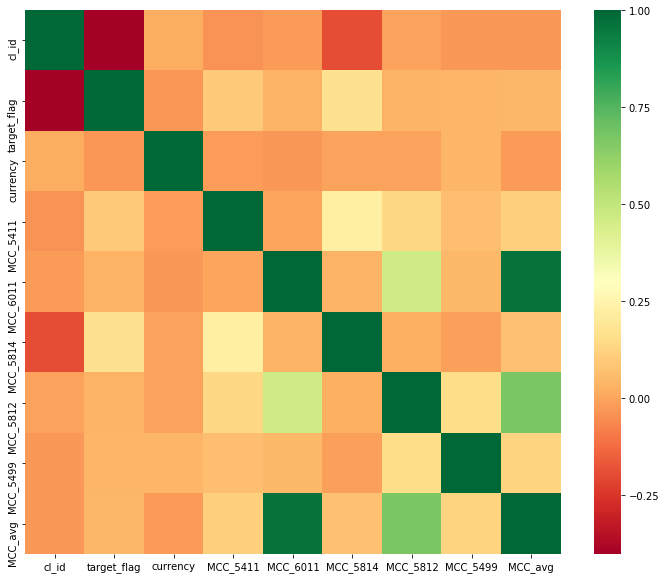

In [18]:
# Проверим сами значения корреляции между числовыми признаками датасета:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cl_ids_train.corr(),annot=False,cmap="RdYlGn");

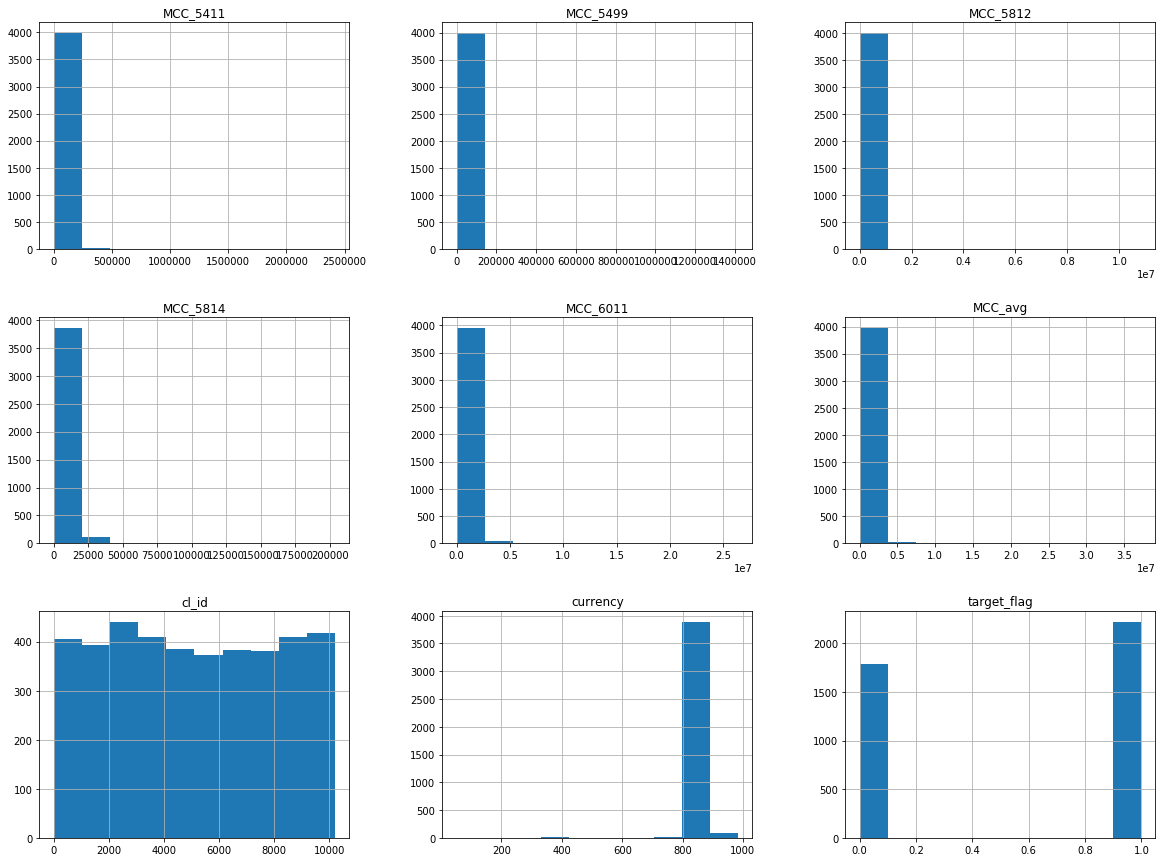

In [19]:
cl_ids_train.hist(figsize=(20,15));

In [22]:
x_train = cl_ids_train[list(set(cl_ids_train.columns).difference(['target_flag','channel_type']))]
y_train = cl_ids_train['target_flag']
x_test = cl_ids_test[list(set(cl_ids_train.columns).difference(['target_flag','channel_type']))]
y_test = cl_ids_test['target_flag']

xgb = xgboost.XGBClassifier(max_depth=7, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.94


In [23]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.91
Test:  0.89


In [24]:
xgb = xgboost.XGBClassifier(max_depth=6, n_jobs=-1)
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.95
Test:  0.92
